In [6]:
#pip install tensorflow
#!pip install split-folders
#!pip install split-folders tqdm
#!pip install googlenet-pytorch

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


In [8]:
#import splitfolders

In [9]:
#splitfolders.ratio(r'C:\Users\ATHIRANIRMAL\Desktop\Athira\output',output = "output1",seed = 1337,ratio = (.7,.3),group_prefix=None)

In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        #_, ftype = os.path.splitext(PATH)
#         if ftype == ".jpg":
        img = read(PATH)
           
        img = cv2.resize(img, (RESIZE,RESIZE))
           
        IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../Medical Image classification/Medical Image Dataset/Train/brain benign',224))#benign
malignant_train = np.array(Dataset_loader('../Medical Image classification/Medical Image Dataset/Train/brain malignant',224))#malignant
benign_test = np.array(Dataset_loader('../Medical Image classification/Medical Image Dataset/Test/Brain ben',224))
malignant_test = np.array(Dataset_loader('../Medical Image classification/Medical Image Dataset/Test/Brain malig',224))




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.79it/s]


In [3]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malignant_train_label = np.ones(len(malignant_train))
benign_test_label = np.zeros(len(benign_test))
malignant_test_label = np.ones(len(malignant_test))

# Merge data 
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)


# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
#print(Y_train)
Y_test = to_categorical(Y_test, num_classes= 2)



In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

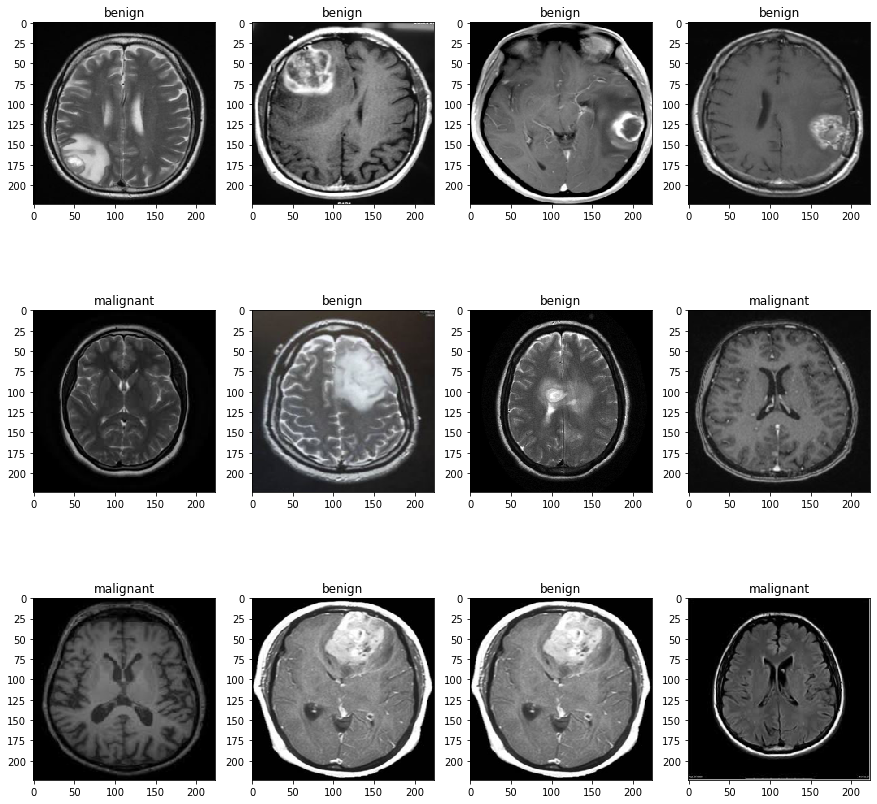

In [15]:
#Display first 12 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('benign')
        
    else:
        ax.title.set_text('malignant')
    plt.imshow(x_train[i], interpolation='nearest')
    #plt.imshow(x_train[i])
#plt.show()

In [5]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [17]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [18]:
K.clear_session()
gc.collect()

resnet = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,815,074
Trainable params: 21,776,546
Non-trainable params: 38,528
_________________________________________________________________


In [26]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="brain.detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [27]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\ATHIRANIRMAL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8/8 [==============================] - 77s 8s/step - loss: 0.6889 - accuracy: 0.7214 - val_loss: 0.6565 - val_accuracy: 0.7500

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to brain.detection.hdf5
Epoch 2/20
8/8 [==============================] - 73s 9s/step - loss: 0.5598 - accuracy: 0.7786 - val_loss: 0.9449 - val_accuracy: 0.7222

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/20
8/8 [==============================] - 71s 8s/step - loss: 0.5298 - accuracy: 0.7714 - val_loss: 1.0132 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.75000 to 0.77778, saving model to brain.detection.hdf5
Epoch 4/20
8/8 [==============================] - 72s 8s/step - loss: 0.5531 - accuracy: 0.7571 - val_loss: 0.7145 - val_accuracy: 0.8056

Epoch 00004: val_accuracy improved from 0.77778 to 0.80556, saving model to brain.detection.hdf5
Epoch 5/20
8/8 [==============================] - 71s 8s/step - loss: 0.5947 - accuracy: 0.7429 - val

In [28]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

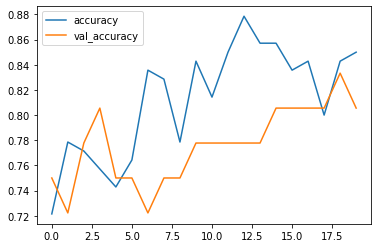

In [29]:

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

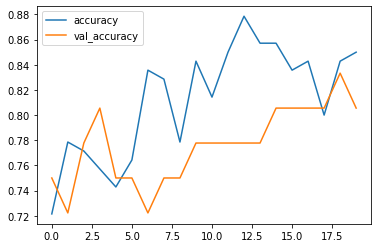

In [30]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [6]:
from keras.models import load_model
model = load_model("breast.detection.hdf5")

In [31]:
model.load_weights("brain.detection.hdf5")

In [7]:
Y_val_pred = model.predict(x_val)

In [8]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.75

In [10]:
Y_pred = model.predict(X_test)

In [35]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\ATHIRANIRMAL\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.20s/it]


Confusion matrix, without normalization
[[37 10]
 [12 18]]


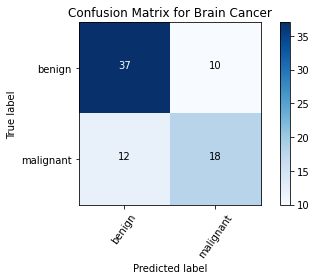

In [11]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Brain Cancer')

In [38]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.95      0.85      0.90        47\n           1       0.80      0.93      0.86        30\n\n    accuracy                           0.88        77\n   macro avg       0.88      0.89      0.88        77\nweighted avg       0.89      0.88      0.88        77\n'

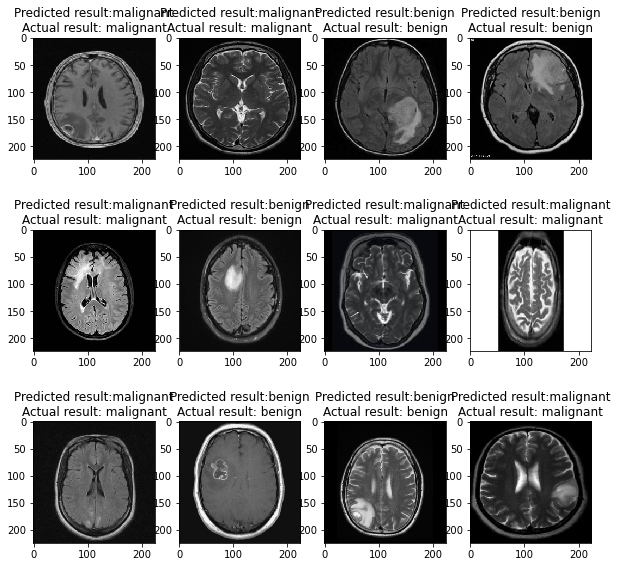

In [40]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==12):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==12):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

def Transfername(namecode):
    if namecode==0:
        return "benign"
    else:
        return "malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()